# Example Notebook for making performance and accuracy benchmarking figure

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import sys
sys.path.insert(0, '../')

import blink
from importlib import reload
reload(blink)

import pandas as pd
import numpy as np
import scipy
from scipy import sparse as sp

from matplotlib import pyplot as plt
import seaborn as sns

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Load data

In [2]:
small  = blink.open_msms_file('./small.mgf')
medium = blink.open_msms_file('./medium.mgf')

S1 = blink.discretize_spectra(small.spectrum,  small.precursor_mz,  intensity_power=0.5)
S2 = blink.discretize_spectra(medium.spectrum, medium.precursor_mz, intensity_power=0.5)

# Run BLINK on 1 million comparisons

In [3]:
%%time
S12 = blink.score_sparse_spectra(S1, S2, tolerance=0.01)

CPU times: user 92.8 ms, sys: 14.7 ms, total: 107 ms
Wall time: 107 ms


# Run MatchMS for Same comparisons

In [4]:
import matchms as mms
from matchms.similarity import CosineGreedy, ModifiedCosine

MMS1 = [mms.Spectrum(s.spectrum[0],
                     s.spectrum[1],
                     metadata={'precursor_mz': s.precursor_mz}) 
        for i,s in small.iterrows()]
MMS2 = [mms.Spectrum(m.spectrum[0],
                     m.spectrum[1],
                     metadata={'precursor_mz': m.precursor_mz}) 
        for i,m in medium.iterrows()]

cos = CosineGreedy(tolerance=0.0099,intensity_power=0.5)
mod = ModifiedCosine(tolerance=0.0099,intensity_power=0.5)

In [5]:
%%time
MMS12 = {}
MMS12['cos'] = cos.matrix(references=MMS1, queries=MMS2)
MMS12['mod'] = mod.matrix(references=MMS1, queries=MMS2)

CPU times: user 1min 32s, sys: 280 ms, total: 1min 33s
Wall time: 1min 33s


# Load Precomputed Compute timing for various numbers of compariosns for MatchMS and BLINK

In [6]:
benchmark_df = pd.read_csv('./blink_benchmark.csv').groupby(['comparisons', 'algorithm']).median()

# Generate Figure in Manuscript

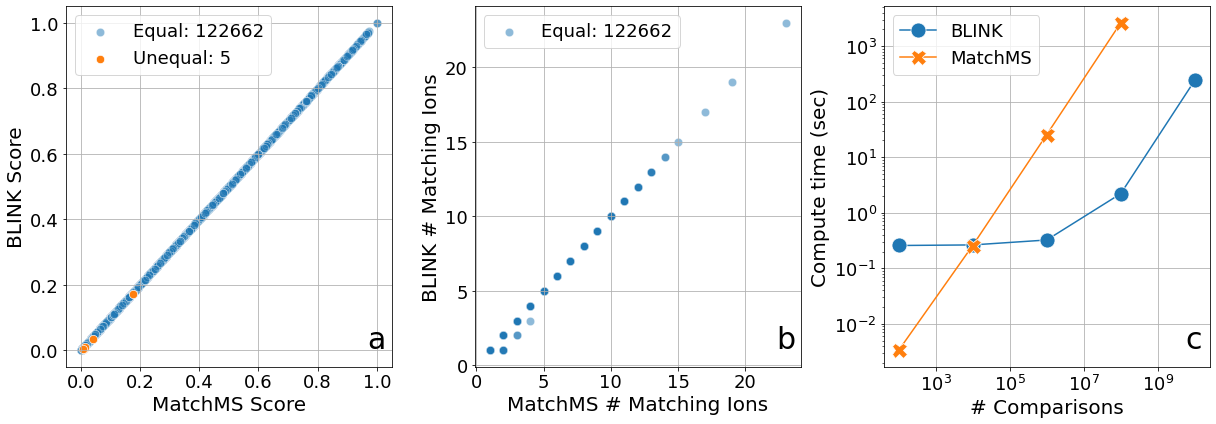

In [7]:
%matplotlib inline
x = MMS12['cos']['score'].flatten()
y = S12['mzi'].toarray().flatten()
x,y = x[(x>0)&(y>0)], y[(x>0)&(y>0)]


fig, ax = plt.subplots(figsize=(17, 6),nrows=1,ncols=3)
ax = ax.flatten()
sns.scatterplot(x=x, y=y, s=70, label='Equal: {}'.format(len(x)), alpha=.5,ax=ax[0])
x,y = x[(y+1e-3<x)|(x<y-1e-3)], y[(x+1e-3<y)|(y<x-1e-3)]
sns.scatterplot(x=x, y=y, s=70, label='Unequal: {}'.format(len(x)),ax=ax[0])
ax[0].set_xlabel('MatchMS Score',fontsize=20)
ax[0].set_ylabel('BLINK Score',fontsize=20)


x = MMS12['cos']['matches'].flatten()
y = S12['mzc'].toarray().flatten()
x,y = x[(x>0)&(y>0)], y[(x>0)&(y>0)]

sns.scatterplot(x=x, y=y, s=70, label='Equal: {}'.format(len(x)), alpha=.5,ax=ax[1])
x,y = x[(y+1<x)|(x<y-1)], y[(x+1<y)|(y<x-1)]
sns.scatterplot(x=x, y=y, s=70, label='Unequal: {}'.format(len(x)),ax=ax[1])
ax[1].set_xlabel('MatchMS # Matching Ions',fontsize=20)
ax[1].set_ylabel('BLINK # Matching Ions',fontsize=20)

 
sns.lineplot(data=benchmark_df, x='comparisons', y='seconds', 
             hue='algorithm', style='algorithm', 
             markers=True, dashes=False,ax=ax[2],markersize=15)

ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[2].set_ylabel('Compute time (sec)',fontsize=20)
ax[2].set_xlabel('# Comparisons',fontsize=20)

for i,a in enumerate(ax):
    a.grid()
    if i==2:
        a.legend(fontsize=18,labels=['BLINK','MatchMS'])
    else:
        a.legend(fontsize=18,loc='upper left')
    
    for label in (a.get_xticklabels() + a.get_yticklabels()):
        label.set_fontsize(18)
    a.text(0.925,0.05,chr(97+i),fontsize=30,transform=a.transAxes)

plt.tight_layout()
plt.show()

fig.savefig('accuracy_benchmarking.pdf')

In [8]:
benchmark_df.reset_index(inplace=True)
timing_df = pd.merge(benchmark_df[benchmark_df['algorithm']=='blink'].add_suffix('_blink'),
         benchmark_df[benchmark_df['algorithm']=='matchms'].add_suffix('_matchms'),
         left_on='comparisons_blink',
         right_on='comparisons_matchms',
         how='inner')
timing_df.head()

,comparisons_blink,algorithm_blink,seconds_blink,comparisons_matchms,algorithm_matchms,seconds_matchms
0,1.000000e+02,blink,0.257273,1.000000e+02,matchms,0.003334
1,1.000000e+04,blink,0.263390,1.000000e+04,matchms,0.257114
2,1.000000e+06,blink,0.323112,1.000000e+06,matchms,25.491312
3,1.000000e+08,blink,2.207324,1.000000e+08,matchms,2631.954724
4,1.000000e+10,blink,242.139770,1.000000e+10,matchms,NaN


In [9]:
timing_df['seconds_matchms']/timing_df['seconds_blink']

0       0.012960
1       0.976172
2      78.893121
3    1192.373695
4            NaN
dtype: float64